In [2336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import rankdata

In [2337]:
berichtinteracties_met_sentiment = pd.read_csv("Datasets/berichtinteracties_met_sentiment.csv",sep=';')
evenementaanwezigheid = pd.read_csv("Datasets/evenementaanwezigheid.csv",sep=';')
evenementinformatie = pd.read_csv("Datasets/evenementinformatie.csv",sep=';')
gebruikersinformatie = pd.read_csv("Datasets/gebruikersinformatie.csv",sep=';')


berichtinteracties_met_sentiment = berichtinteracties_met_sentiment.drop_duplicates()
evenementaanwezigheid = evenementaanwezigheid.drop_duplicates()
evenementinformatie = evenementinformatie.drop_duplicates()
gebruikersinformatie = gebruikersinformatie.drop_duplicates()

kijke of er mesen LaatsteLogin zijn voor dat ze LaatsteLogin RegistratieDatum

In [2338]:
gebruikersinformatie['RegistratieDatum'] = pd.to_datetime(gebruikersinformatie['RegistratieDatum'], format='%d-%m-%Y', errors='coerce')
gebruikersinformatie['LaatsteLogin'] = pd.to_datetime(gebruikersinformatie['LaatsteLogin'], format='%d-%m-%Y', errors='coerce')

true_rows = gebruikersinformatie['RegistratieDatum'] > gebruikersinformatie['LaatsteLogin']

print(true_rows[true_rows == True])

Series([], dtype: bool)


als leeft null is verander door gemidel Leeftijd
en als Lidmaatschapstype X is verander door Regulier

In [2339]:
int(gebruikersinformatie["Leeftijd"].mean())

gebruikersinformatie["Leeftijd"] = gebruikersinformatie["Leeftijd"].fillna(int(gebruikersinformatie["Leeftijd"].mean()))


gebruikersinformatie["Lidmaatschapstype"] = gebruikersinformatie["Lidmaatschapstype"].apply(
    lambda x: "Regulier" if x == "x" else x
)


als Studierichting verander dat er geen hooflet probllemn zijn en dus geen dubble data bestaat 

In [2340]:
gebruikersinformatie['Studierichting'] = gebruikersinformatie['Studierichting'].str.strip().str.lower()

gebruikersinformatie['Studierichting'] = gebruikersinformatie['Studierichting'].str.title()


heg haalen van all waar Afwezig & Bijgewoond op het zelde momet en naar Bijgewoond

In [2341]:
even = evenementaanwezigheid.drop_duplicates()

grouped_data = even.groupby(["EvenementID", "GebruikerID"]).agg(
    Count=("Aanwezigheidsstatus", "size"),  # Aantal rijen per groep
    AanwezigheidsstatusList=("Aanwezigheidsstatus", list)  # Lijst van Aanwezigheidsstatus
).reset_index()

duplicates = grouped_data[grouped_data["Count"] > 1]
is_Afwezig = duplicates[duplicates["AanwezigheidsstatusList"].apply(lambda x: "Afwezig" in x and "Bijgewoond" in x)]

print(is_Afwezig)

evenementaanwezigheid = evenementaanwezigheid[
    ~(
        (evenementaanwezigheid["EvenementID"].isin(is_Afwezig["EvenementID"])) &
        (evenementaanwezigheid["GebruikerID"].isin(is_Afwezig["GebruikerID"])) &
        (evenementaanwezigheid["Aanwezigheidsstatus"] == "Afwezig")
    )
]
print(evenementaanwezigheid)

     EvenementID GebruikerID  Count               AanwezigheidsstatusList
24          E001        G107      2                 [Afwezig, Bijgewoond]
38          E001        G163      2                 [Afwezig, Bijgewoond]
113         E002        G142      2                 [Afwezig, Bijgewoond]
141         E002        G246      2                 [Bijgewoond, Afwezig]
150         E002        G269      2                 [Bijgewoond, Afwezig]
...          ...         ...    ...                                   ...
3330        E039        G260      2                 [Afwezig, Bijgewoond]
3347        E040        G008      3  [Afwezig, Geregistreerd, Bijgewoond]
3363        E040        G049      2                 [Afwezig, Bijgewoond]
3366        E040        G061      2                 [Afwezig, Bijgewoond]
3399        E040        G212      2                 [Afwezig, Bijgewoond]

[128 rows x 4 columns]
     EvenementID GebruikerID Aanwezigheidsstatus
0           E003        G131           

het weg haalen van waar een bericht is getuur ok al is de persoon niet bij de evenementaanwezigheid aan wezig 

In [2342]:

# Filter rows where conditions are met
merged_data = pd.merge(
    evenementaanwezigheid,
    berichtinteracties_met_sentiment,
    on=["EvenementID", "GebruikerID"],
    how="inner"  # Alleen rijen die overeenkomen worden behouden
)

grouped_data = merged_data.groupby(["EvenementID", "GebruikerID"]).agg(
    Count=("Aanwezigheidsstatus", "size"),  # Aantal rijen per groep
    AanwezigheidsstatusList=("Aanwezigheidsstatus", list),  # Lijst van Aanwezigheidsstatus
).reset_index()

duplicates = grouped_data[grouped_data["Count"] > 0]
is_Afwezig = duplicates[duplicates["AanwezigheidsstatusList"].apply(lambda x: len(set(x))==1 and "Afwezig" in x)]

result = pd.merge(is_Afwezig, berichtinteracties_met_sentiment, on=["EvenementID", "GebruikerID"], how="inner")


berichtinteracties_met_sentiment = berichtinteracties_met_sentiment[
    ~(
        (berichtinteracties_met_sentiment["EvenementID"].isin(result["EvenementID"])) &
        (berichtinteracties_met_sentiment["GebruikerID"].isin(result["GebruikerID"]))
    )
]
print(berichtinteracties_met_sentiment)

    BerichtID BerichtDatum GebruikerID EvenementID BerichtSentiment  \
0        B001    18-5-2023        G309        E012         Neutraal   
1        B002    6-10-2023        G021        E039         Positief   
2        B003     7-7-2023        G111        E001         Positief   
3        B004    5-10-2023        G168        E015         Negatief   
4        B005    22-1-2023        G076        E017         Neutraal   
..        ...          ...         ...         ...              ...   
494      B495     3-3-2023        G210        E025         Positief   
495      B496    16-2-2023        G263        E010         Neutraal   
497      B498   18-12-2023        G005        E004         Positief   
498      B499     5-6-2023        G243        E013         Positief   
499      B500   27-12-2023        G068        E018         Positief   

     OntvangenLikes  OntvangenReacties  
0                 5                  8  
1                 9                  6  
2                 8     

Aanwezigheidsstatus verader naar Afwezig Bijgewoond Geregistreerd

In [2343]:

df = pd.DataFrame(evenementaanwezigheid)

# Maak drie nieuwe kolommen met 1 of 0 voor elke status
df["Afwezig"] = (df["Aanwezigheidsstatus"] == "Afwezig").astype(int)
df["Bijgewoond"] = (df["Aanwezigheidsstatus"] == "Bijgewoond").astype(int)
df["Geregistreerd"] = (df["Aanwezigheidsstatus"] == "Geregistreerd").astype(int)

# Verwijder de oude kolom
df = df.drop(columns=["Aanwezigheidsstatus"])
df = df.groupby(["EvenementID", "GebruikerID"], as_index=False).max()
# Toon de eerste paar rijenkijken
print(df)
evenementaanwezigheid = df

     EvenementID GebruikerID  Afwezig  Bijgewoond  Geregistreerd
0           E001        G002        0           1              0
1           E001        G005        0           0              1
2           E001        G009        0           0              1
3           E001        G012        0           0              1
4           E001        G019        0           1              1
...          ...         ...      ...         ...            ...
3100        E040        G302        0           1              0
3101        E040        G307        1           0              0
3102        E040        G310        1           0              0
3103        E040        G312        1           0              0
3104        E040        G317        0           1              1

[3105 rows x 5 columns]


print data

In [2344]:
berichtinteracties_met_sentiment
evenementaanwezigheid 
evenementinformatie
gebruikersinformatie
print("berichtinteracties_met_sentiment")
print(berichtinteracties_met_sentiment)
print("evenementaanwezigheid")
print(evenementaanwezigheid)
print("evenementinformatie")
print(evenementinformatie)
print("gebruikersinformatie")
print(gebruikersinformatie)


berichtinteracties_met_sentiment
    BerichtID BerichtDatum GebruikerID EvenementID BerichtSentiment  \
0        B001    18-5-2023        G309        E012         Neutraal   
1        B002    6-10-2023        G021        E039         Positief   
2        B003     7-7-2023        G111        E001         Positief   
3        B004    5-10-2023        G168        E015         Negatief   
4        B005    22-1-2023        G076        E017         Neutraal   
..        ...          ...         ...         ...              ...   
494      B495     3-3-2023        G210        E025         Positief   
495      B496    16-2-2023        G263        E010         Neutraal   
497      B498   18-12-2023        G005        E004         Positief   
498      B499     5-6-2023        G243        E013         Positief   
499      B500   27-12-2023        G068        E018         Positief   

     OntvangenLikes  OntvangenReacties  
0                 5                  8  
1                 9             

snel even kijken what we kunnen zien 

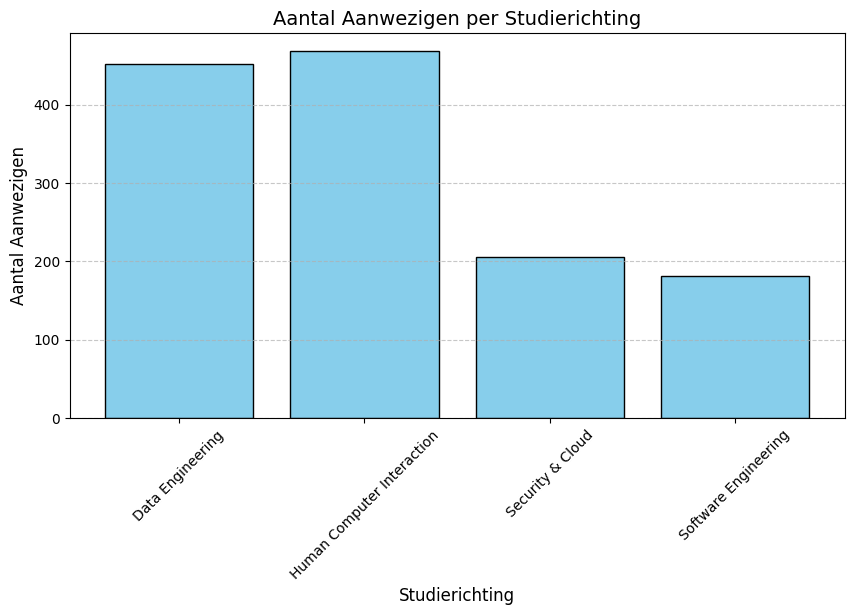

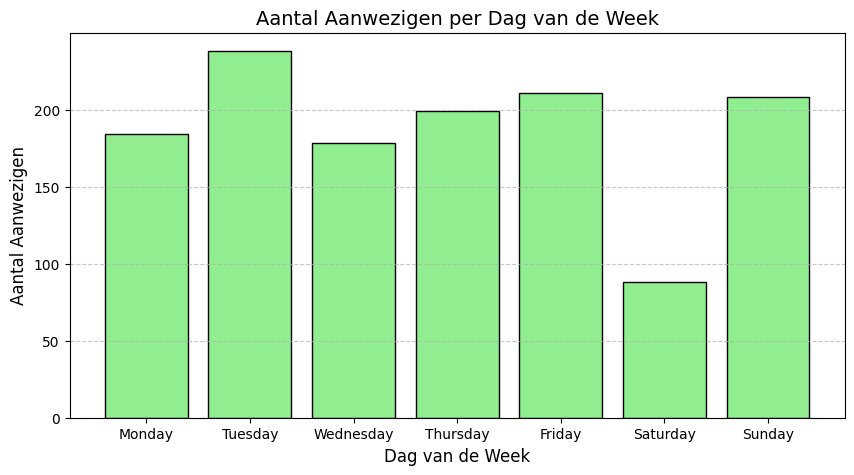

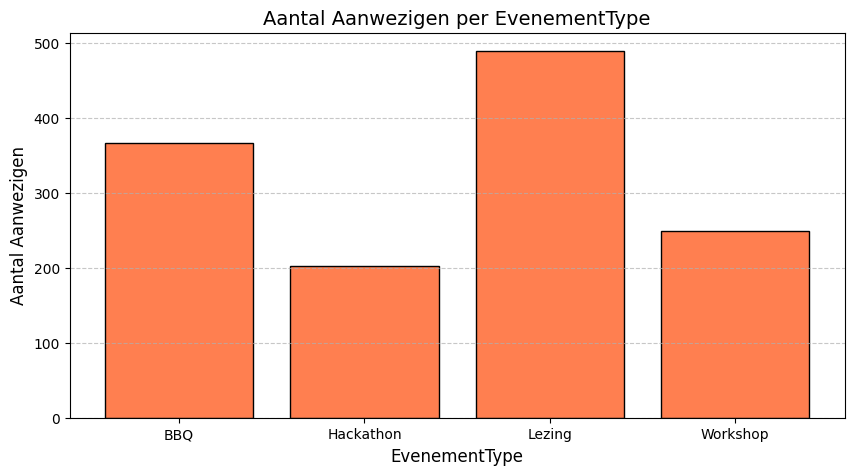

In [2355]:
# Voeg de aanwezigheid per evenement en gebruiker samen
aanwezigheid = evenementaanwezigheid[['EvenementID', 'GebruikerID', 'Bijgewoond']]

# Voeg studierichting en lidmaatschapstype van de gebruiker toe aan aanwezigheid
gebruikers_info = gebruikersinformatie[['GebruikerID', 'Studierichting']]
aanwezigheid = pd.merge(aanwezigheid, gebruikers_info, on='GebruikerID', how='left')

# Voeg EvenementType uit evenementinformatie toe aan de aanwezigheid
evenement_info = evenementinformatie[['EvenementID', 'EvenementType']]
aanwezigheid = pd.merge(aanwezigheid, evenement_info, on='EvenementID', how='left')

aanwezigheid = pd.merge(aanwezigheid, evenementinformatie[['EvenementID', 'EvenementDatum']], on='EvenementID', how='left')
aanwezigheid['EvenementDatum'] = pd.to_datetime(aanwezigheid['EvenementDatum'])
aanwezigheid['DagVanDeWeek'] = aanwezigheid['EvenementDatum'].dt.day_name()

# --- Analyse op Studierichting ---
studierichting_opkomst = aanwezigheid.groupby('Studierichting')['Bijgewoond'].apply(lambda x: (x == 1).sum()).reset_index()
studierichting_opkomst.columns = ['Studierichting', 'Aantal Aanwezigen']

# --- Analyse op Dag van de Week ---
dag_opkomst = aanwezigheid.groupby('DagVanDeWeek')['Bijgewoond'].apply(lambda x: (x == 1).sum()).reset_index()
dag_opkomst.columns = ['DagVanDeWeek', 'Aantal Aanwezigen']

# Sorteer de dagen van de week
dag_volgorde = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dag_opkomst['DagVanDeWeek'] = pd.Categorical(dag_opkomst['DagVanDeWeek'], categories=dag_volgorde, ordered=True)
dag_opkomst = dag_opkomst.sort_values('DagVanDeWeek')

# --- Analyse op EvenementType ---
evenementtype_opkomst = aanwezigheid.groupby('EvenementType')['Bijgewoond'].apply(lambda x: (x == 1).sum()).reset_index()
evenementtype_opkomst.columns = ['EvenementType', 'Aantal Aanwezigen']

# --- Visualisaties ---

# 1. Visualiseer opkomst per opleiding
plt.figure(figsize=(10, 5))
plt.bar(studierichting_opkomst['Studierichting'], studierichting_opkomst['Aantal Aanwezigen'], color='skyblue', edgecolor='black')
plt.title('Aantal Aanwezigen per Studierichting', fontsize=14)
plt.xlabel('Studierichting', fontsize=12)
plt.ylabel('Aantal Aanwezigen', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

# 2. Visualiseer opkomst per dag van de week
plt.figure(figsize=(10, 5))
plt.bar(dag_opkomst['DagVanDeWeek'], dag_opkomst['Aantal Aanwezigen'], color='lightgreen', edgecolor='black')
plt.title('Aantal Aanwezigen per Dag van de Week', fontsize=14)
plt.xlabel('Dag van de Week', fontsize=12)
plt.ylabel('Aantal Aanwezigen', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Visualiseer opkomst per EvenementType
plt.figure(figsize=(10, 5))
plt.bar(evenementtype_opkomst['EvenementType'], evenementtype_opkomst['Aantal Aanwezigen'], color='coral', edgecolor='black')
plt.title('Aantal Aanwezigen per EvenementType', fontsize=14)
plt.xlabel('EvenementType', fontsize=12)
plt.ylabel('Aantal Aanwezigen', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


supervised-learning

Voorspellen van aanwezigheid op evenementen

C:\Users\Stefa\AppData\Local\Temp\ipykernel_16700\585287144.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data_type = X_test[aanwezigheid['EvenementType'] == evenement_type_num]


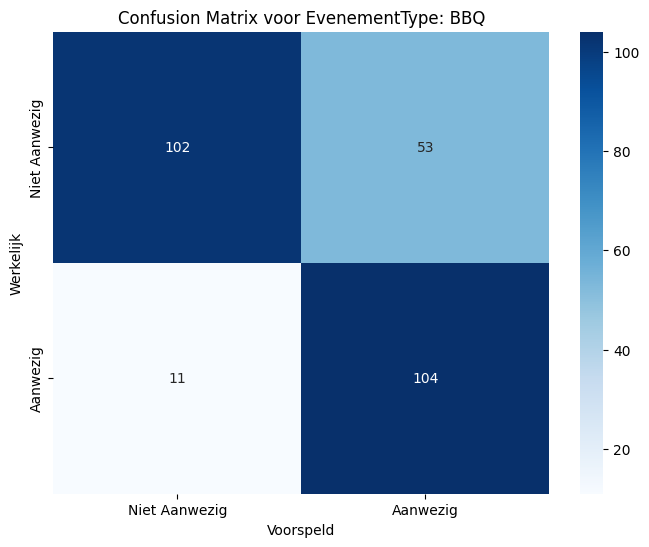

C:\Users\Stefa\AppData\Local\Temp\ipykernel_16700\585287144.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data_type = X_test[aanwezigheid['EvenementType'] == evenement_type_num]


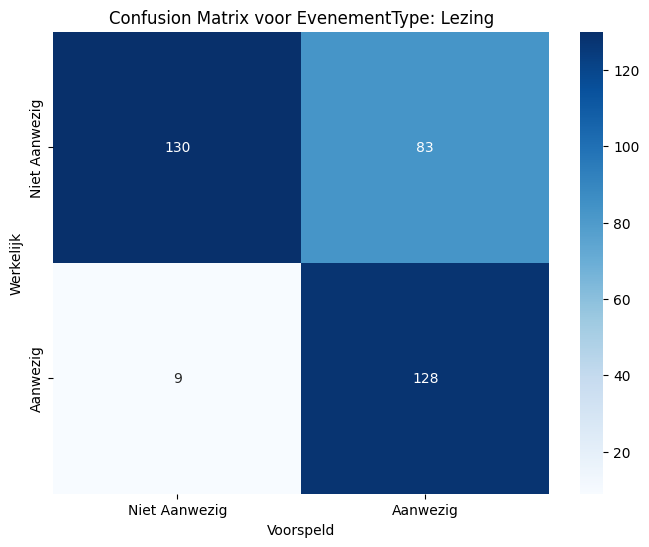

C:\Users\Stefa\AppData\Local\Temp\ipykernel_16700\585287144.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data_type = X_test[aanwezigheid['EvenementType'] == evenement_type_num]


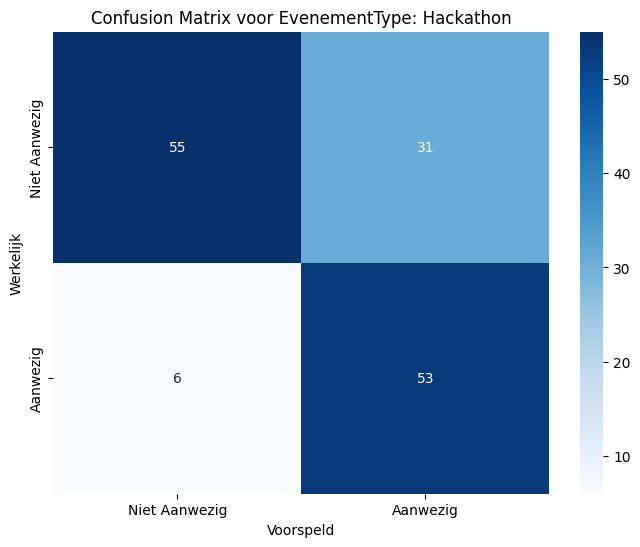

C:\Users\Stefa\AppData\Local\Temp\ipykernel_16700\585287144.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data_type = X_test[aanwezigheid['EvenementType'] == evenement_type_num]


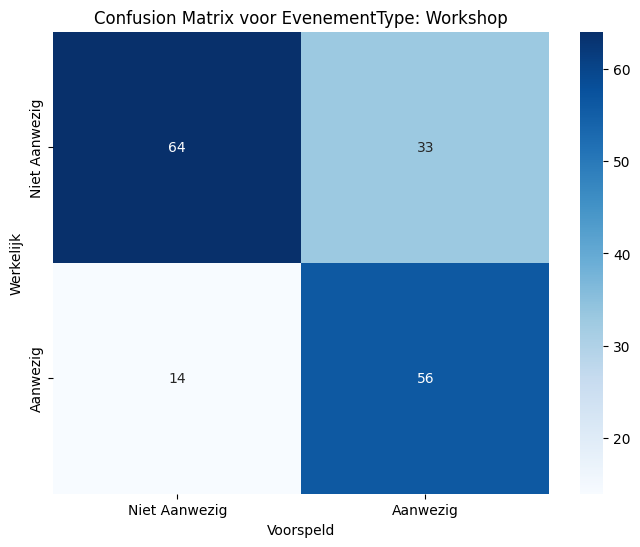

In [2356]:

aanwezigheid = evenementaanwezigheid[['EvenementID', 'GebruikerID', 'Bijgewoond', 'Geregistreerd']]

gebruikers_info = gebruikersinformatie[['GebruikerID', 'Studierichting', 'Leeftijd', 'Lidmaatschapstype']]
aanwezigheid = pd.merge(aanwezigheid, gebruikers_info, on='GebruikerID', how='left')

evenement_info = evenementinformatie[['EvenementID', 'EvenementType']]
aanwezigheid = pd.merge(aanwezigheid, evenement_info, on='EvenementID', how='left')

aanwezigheid = pd.merge(aanwezigheid, evenementinformatie[['EvenementID', 'EvenementDatum']], on='EvenementID', how='left')
aanwezigheid['EvenementDatum'] = pd.to_datetime(aanwezigheid['EvenementDatum'])
aanwezigheid['DagVanDeWeek'] = aanwezigheid['EvenementDatum'].dt.day_name()



aanwezigheid['Studierichting'] = pd.factorize(aanwezigheid['Studierichting'])[0]
aanwezigheid['EvenementType'] = pd.factorize(aanwezigheid['EvenementType'])[0]
aanwezigheid['Lidmaatschapstype'] = pd.factorize(aanwezigheid['Lidmaatschapstype'])[0]
aanwezigheid['DagVanDeWeek'] = pd.Categorical(aanwezigheid['DagVanDeWeek'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
aanwezigheid['DagVanDeWeek'] = aanwezigheid['DagVanDeWeek'].cat.codes


# Definieer de features (X) en de target (y)
X = aanwezigheid[['Leeftijd', 'Studierichting', 'Lidmaatschapstype', 'EvenementType', 'DagVanDeWeek', 'Geregistreerd']]
y = aanwezigheid['Bijgewoond']

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#  Maak het model aan en train het
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

#  Maak voorspellingen
y_pred = model.predict(X_test)


evenement_types = aanwezigheid['EvenementType'].unique()
evenement_type_mapping = dict(zip(evenementinformatie['EvenementType'].unique(), 
                                  range(len(evenementinformatie['EvenementType'].unique()))))
aanwezigheid['EvenementTypeNaam'] = aanwezigheid['EvenementType'].map({v: k for k, v in evenement_type_mapping.items()})
for evenement_type_num in evenement_types:
    test_data_type = X_test[aanwezigheid['EvenementType'] == evenement_type_num]
    true_labels = y_test[aanwezigheid['EvenementType'] == evenement_type_num]
    if len(test_data_type) > 0:
        predictions = model.predict(test_data_type)
        conf_matrix = confusion_matrix(true_labels, predictions)
        evenement_type_name = aanwezigheid[aanwezigheid['EvenementType'] == evenement_type_num]['EvenementTypeNaam'].iloc[0]
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Niet Aanwezig', 'Aanwezig'], 
                    yticklabels=['Niet Aanwezig', 'Aanwezig'])
        plt.title(f'Confusion Matrix voor EvenementType: {evenement_type_name}')
        plt.xlabel('Voorspeld')
        plt.ylabel('Werkelijk')
        plt.show()
    else:
        print(f"Geen testdata beschikbaar voor EvenementType {evenement_type_num}.")



3.	Effect van berichten op opkomst

C:\Users\Stefa\AppData\Local\Temp\ipykernel_16700\1244649669.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='BerichtTiming', y='Bijgewoond', data=opkomst_per_bericht_timing, palette='Blues')


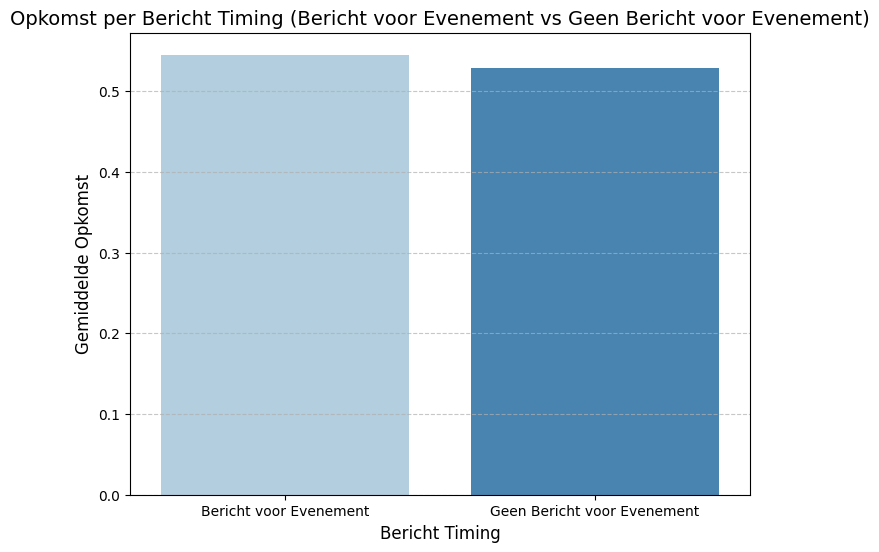

In [2357]:
bms = berichtinteracties_met_sentiment
ewh = evenementaanwezigheid
evi = evenementinformatie

bms['BerichtDatum'] = pd.to_datetime(berichtinteracties_met_sentiment['BerichtDatum'])
ewh['EvenementID'] = evenementaanwezigheid['EvenementID'].astype(str)
evi['EvenementID'] = evenementinformatie['EvenementID'].astype(str)
evi['EvenementDatum'] = pd.to_datetime(evenementinformatie['EvenementDatum'])

evenementaanwezigheid2 = ewh.merge(
    evi[['EvenementID',"EvenementDatum"]], 
    on='EvenementID', 
    how='left'
)
berichtinteracties_met_sentiment2 = bms.merge(
    evenementaanwezigheid[['EvenementID', 'GebruikerID','Bijgewoond']], 
    on=['EvenementID', 'GebruikerID'], 
    how='left'
)

berichtinteracties_met_sentiment2['TijdTotEvenement'] = (evenementaanwezigheid2['EvenementDatum'] - berichtinteracties_met_sentiment2['BerichtDatum']).dt.days

berichtinteracties_met_sentiment2['BerichtTiming'] = np.where(berichtinteracties_met_sentiment2['TijdTotEvenement'] > 0, 'Bericht voor Evenement', 'Geen Bericht voor Evenement')

opkomst_per_bericht_timing = berichtinteracties_met_sentiment2.groupby('BerichtTiming')['Bijgewoond'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='BerichtTiming', y='Bijgewoond', data=opkomst_per_bericht_timing, palette='Blues')
plt.title('Opkomst per Bericht Timing (Bericht voor Evenement vs Geen Bericht voor Evenement)', fontsize=14)
plt.xlabel('Bericht Timing', fontsize=12)
plt.ylabel('Gemiddelde Opkomst', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


4.	Lidmaatschapstype en betrokkenheid

C:\Users\Stefa\AppData\Local\Temp\ipykernel_16700\610794904.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lidmaatschapstype', y='Betrokkenheid', data=opkomst_per_lidmaatschapstype, palette='Set2')


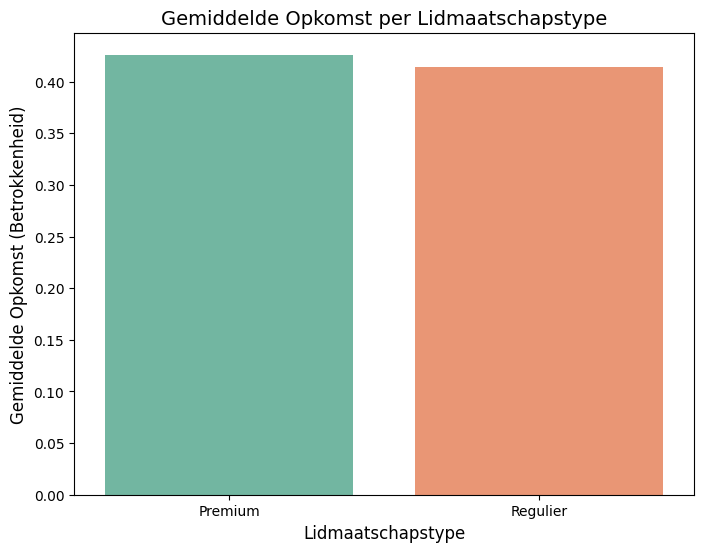

T-statistic: -0.6537185990493118
P-value: 0.5133415574437571
Er is geen significant verschil in opkomst tussen Regulier en Premium.


In [2358]:


evenementaanwezigheid2 = evenementaanwezigheid.merge(
    gebruikersinformatie[['GebruikerID', 'Lidmaatschapstype']],
    on='GebruikerID',
    how='left'
)

evenementaanwezigheid2['Betrokkenheid'] = evenementaanwezigheid2['Bijgewoond'].apply(lambda x: 1 if x == 1 else 0)

opkomst_per_lidmaatschapstype = evenementaanwezigheid2.groupby('Lidmaatschapstype')['Betrokkenheid'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Lidmaatschapstype', y='Betrokkenheid', data=opkomst_per_lidmaatschapstype, palette='Set2')
plt.title('Gemiddelde Opkomst per Lidmaatschapstype', fontsize=14)
plt.xlabel('Lidmaatschapstype', fontsize=12)
plt.ylabel('Gemiddelde Opkomst (Betrokkenheid)', fontsize=12)
plt.show()

from scipy.stats import ttest_ind

regulier_opkomst = evenementaanwezigheid2[evenementaanwezigheid2['Lidmaatschapstype'] == 'Regulier']['Betrokkenheid']
premium_opkomst = evenementaanwezigheid2[evenementaanwezigheid2['Lidmaatschapstype'] == 'Premium']['Betrokkenheid']

t_stat, p_value = ttest_ind(regulier_opkomst, premium_opkomst)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Er is een significant verschil in opkomst tussen Regulier en Premium.")
else:
    print("Er is geen significant verschil in opkomst tussen Regulier en Premium.")


5.	Nieuwe feature: No-shows voorspellen

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       581
           1       0.80      0.72      0.76       351

    accuracy                           0.83       932
   macro avg       0.82      0.81      0.81       932
weighted avg       0.83      0.83      0.83       932



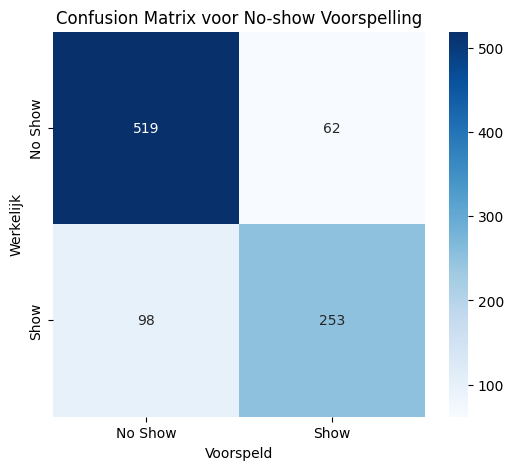

In [2359]:
eazh = evenementaanwezigheid

eazh['NoShow'] = np.where((evenementaanwezigheid['Geregistreerd'] == 1) & (evenementaanwezigheid['Bijgewoond'] == 0), 1, 0)

evenementaanwezigheid2 = eazh.merge(gebruikersinformatie[['GebruikerID', 'Leeftijd', 'Lidmaatschapstype']], on='GebruikerID', how='left')
evenementaanwezigheid2 = evenementaanwezigheid2.merge(evenementinformatie[['EvenementID', 'EvenementType', 'EvenementDatum']], on='EvenementID', how='left')

evenementaanwezigheid2['EvenementDatum'] = pd.to_datetime(evenementaanwezigheid2['EvenementDatum'])
evenementaanwezigheid2['Tijdsverschil'] = (evenementaanwezigheid2['EvenementDatum'] - pd.to_datetime(evenementaanwezigheid2['Geregistreerd'])).dt.days

evenementaanwezigheid2 = pd.get_dummies(evenementaanwezigheid2, columns=['Lidmaatschapstype', 'EvenementType'], drop_first=True)

features = ['Leeftijd', 'Tijdsverschil'] + [col for col in evenementaanwezigheid2.columns if col.startswith('Lidmaatschapstype_') or col.startswith('EvenementType_')]  # Dynamisch de nieuwe kolommen gebruiken na get_dummies
X = evenementaanwezigheid2[features] 
y = evenementaanwezigheid2['NoShow']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Show', 'Show'], yticklabels=['No Show', 'Show'])
plt.title('Confusion Matrix voor No-show Voorspelling')
plt.xlabel('Voorspeld')
plt.ylabel('Werkelijk')
plt.show()


7.	Patronen in no-shows

              precision    recall  f1-score   support

           0       0.63      0.78      0.70       581
           1       0.39      0.23      0.29       351

    accuracy                           0.57       932
   macro avg       0.51      0.51      0.49       932
weighted avg       0.54      0.57      0.54       932



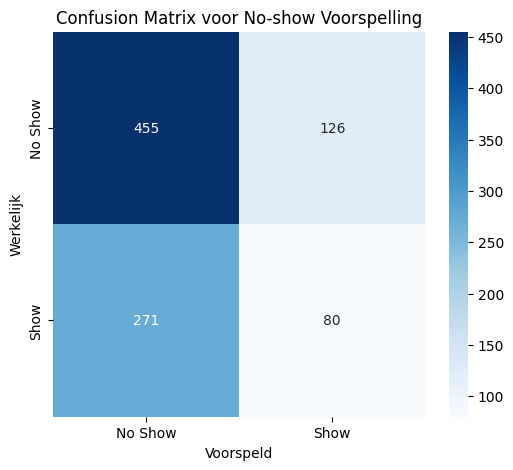

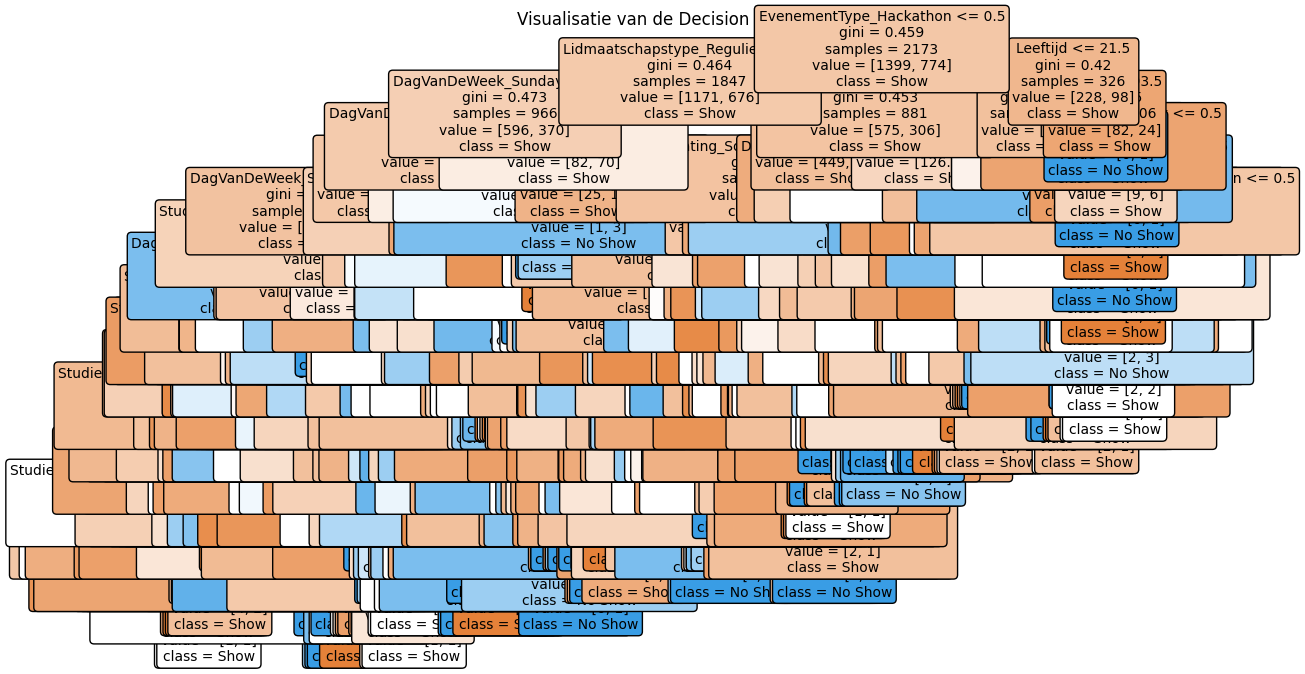

In [2360]:
eazh = evenementaanwezigheid

eazh['NoShow'] = np.where((evenementaanwezigheid['Geregistreerd'] == 1) & (evenementaanwezigheid['Bijgewoond'] == 0), 1, 0)

evenementaanwezigheid2 = eazh.merge(gebruikersinformatie[['GebruikerID', 'Leeftijd', 'Lidmaatschapstype', 'Studierichting', 'Studiejaar']], on='GebruikerID', how='left')
evenementaanwezigheid2 = evenementaanwezigheid2.merge(evenementinformatie[['EvenementID', 'EvenementType', 'EvenementDatum']], on='EvenementID', how='left')

evenementaanwezigheid2['EvenementDatum'] = pd.to_datetime(evenementaanwezigheid2['EvenementDatum'])
evenementaanwezigheid2['DagVanDeWeek'] = evenementaanwezigheid2['EvenementDatum'].dt.day_name()  # Voegt de dag van de week toe

evenementaanwezigheid2 = pd.get_dummies(evenementaanwezigheid2, columns=['Lidmaatschapstype', 'Studierichting', 'EvenementType', 'DagVanDeWeek'], drop_first=True)

features = ['Leeftijd'] + [col for col in evenementaanwezigheid2.columns if col.startswith('Lidmaatschapstype_') or col.startswith('Studierichting_') or col.startswith('EvenementType_') or col.startswith('DagVanDeWeek_')]  # Dynamisch de nieuwe kolommen gebruiken na get_dummies
X = evenementaanwezigheid2[features]  # De geselecteerde features
y = evenementaanwezigheid2['NoShow']  # Target: NoShow

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Show', 'Show'], yticklabels=['No Show', 'Show'])
plt.title('Confusion Matrix voor No-show Voorspelling')
plt.xlabel('Voorspeld')
plt.ylabel('Werkelijk')
plt.show()

from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=features, class_names=['Show', 'No Show'], filled=True, rounded=True, fontsize=10)
plt.title('Visualisatie van de Decision Tree')
plt.show()




8.	Herhalingsgedrag analyseren

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        89
           1       0.97      0.97      0.97       843

    accuracy                           0.94       932
   macro avg       0.84      0.82      0.83       932
weighted avg       0.94      0.94      0.94       932



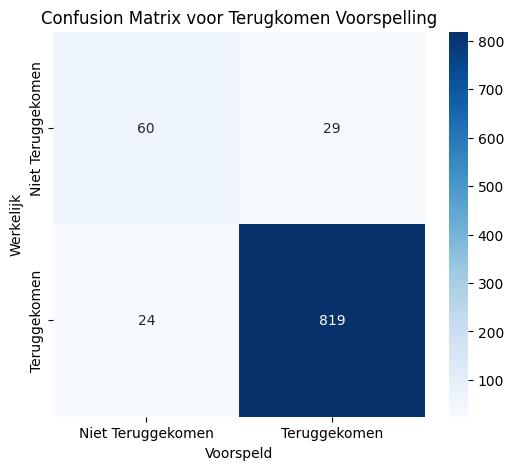

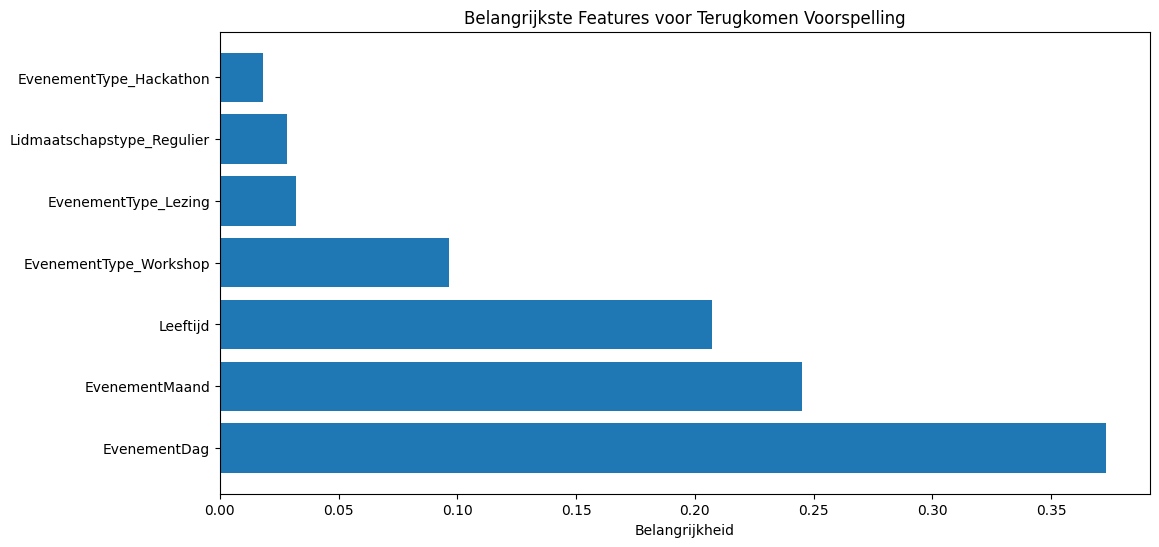

In [2361]:


vereiste_gebruikerskolommen = {'GebruikerID', 'Leeftijd', 'Lidmaatschapstype'}
vereiste_evenementkolommen = {'EvenementID', 'EvenementType', 'EvenementDatum'}

if not vereiste_gebruikerskolommen.issubset(gebruikersinformatie.columns):
    raise KeyError(f"Ontbrekende kolommen in gebruikersinformatie: {vereiste_gebruikerskolommen - set(gebruikersinformatie.columns)}")
if not vereiste_evenementkolommen.issubset(evenementinformatie.columns):
    raise KeyError(f"Ontbrekende kolommen in evenementinformatie: {vereiste_evenementkolommen - set(evenementinformatie.columns)}")

eazh = evenementaanwezigheid
eazh['OpnieuwKomen'] = np.where(evenementaanwezigheid['GebruikerID'].duplicated(keep='last'), 1, 0)

evenementaanwezigheid2 = eazh.merge(
    gebruikersinformatie[['GebruikerID', 'Leeftijd', 'Lidmaatschapstype']], 
    on='GebruikerID', 
    how='left'
)

evenementaanwezigheid2 = evenementaanwezigheid2.merge(
    evenementinformatie[['EvenementID', 'EvenementType', 'EvenementDatum']], 
    on='EvenementID', 
    how='left'
)

evenementaanwezigheid2['EvenementDatum'] = pd.to_datetime(evenementaanwezigheid2['EvenementDatum'], errors='coerce')
evenementaanwezigheid2['EvenementDag'] = evenementaanwezigheid2['EvenementDatum'].dt.day
evenementaanwezigheid2['EvenementMaand'] = evenementaanwezigheid2['EvenementDatum'].dt.month
evenementaanwezigheid2.drop(columns=['EvenementDatum'], inplace=True)  # Oude datumkolom verwijderen

evenementaanwezigheid2.fillna({'Lidmaatschapstype': 'Onbekend', 'EvenementType': 'Onbekend'}, inplace=True)
evenementaanwezigheid2 = pd.get_dummies(evenementaanwezigheid2, columns=['Lidmaatschapstype', 'EvenementType'], drop_first=True)

features = ['Leeftijd', 'EvenementDag', 'EvenementMaand'] + [
    col for col in evenementaanwezigheid2.columns if col.startswith('Lidmaatschapstype_') or col.startswith('EvenementType_')
]
X = evenementaanwezigheid2[features]
y = evenementaanwezigheid2['OpnieuwKomen']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Niet Teruggekomen', 'Teruggekomen'], yticklabels=['Niet Teruggekomen', 'Teruggekomen'])
plt.title('Confusion Matrix voor Terugkomen Voorspelling')
plt.xlabel('Voorspeld')
plt.ylabel('Werkelijk')
plt.show()

feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.barh(range(len(features)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(features)), np.array(features)[sorted_idx])
plt.xlabel('Belangrijkheid')
plt.title('Belangrijkste Features voor Terugkomen Voorspelling')
plt.show()


Unsupervised Learning 

1.	Analyse van evenementenpopulariteit

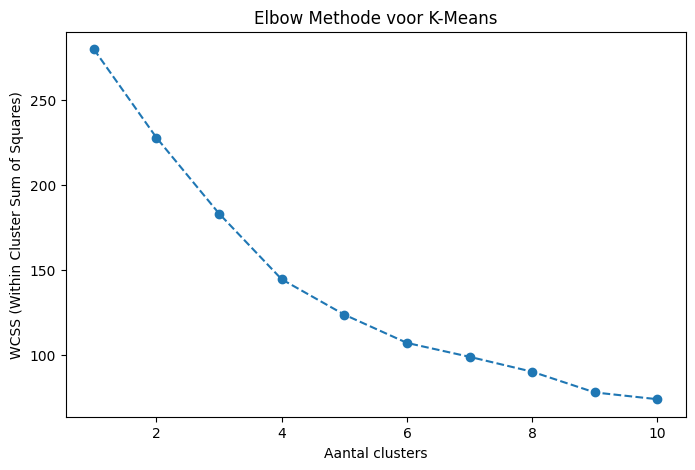

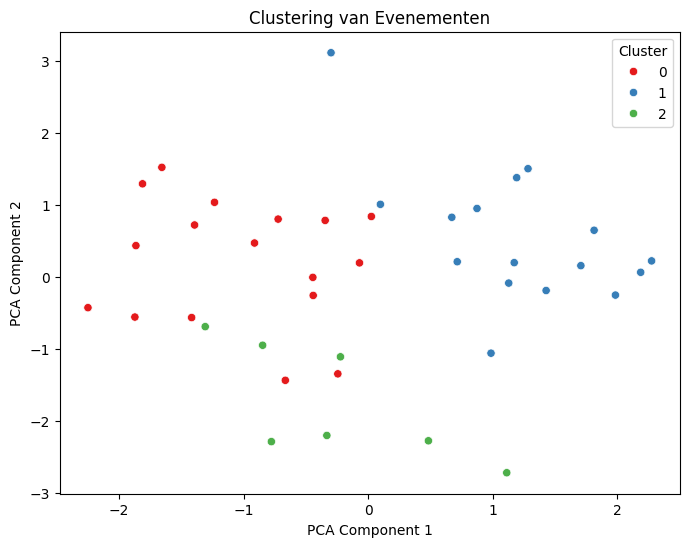

         AantalDeelnemers  DagVanDeWeek     Maand  GemiddeldeLeeftijd  \
Cluster                                                                 
0               75.235294      3.352941  7.705882           20.364145   
1               79.000000      2.375000  5.687500           20.171477   
2               80.285714      3.142857  5.285714           20.125170   

         EvenementType_Hackathon  EvenementType_Lezing  EvenementType_Workshop  
Cluster                                                                         
0                       0.352941                0.0000                     0.0  
1                       0.000000                0.9375                     0.0  
2                       0.000000                0.0000                     1.0  


In [2362]:


vereiste_kolommen = {'EvenementID', 'EvenementType', 'EvenementDatum'}
if not vereiste_kolommen.issubset(evenementinformatie.columns) or 'GebruikerID' not in evenementaanwezigheid.columns:
    raise KeyError("Ontbrekende kolommen in de dataset")

aantal_deelnemers = evenementaanwezigheid.groupby('EvenementID')['GebruikerID'].count().reset_index()
aantal_deelnemers.rename(columns={'GebruikerID': 'AantalDeelnemers'}, inplace=True)

gemiddelde_leeftijd = evenementaanwezigheid.merge(
    gebruikersinformatie[['GebruikerID', 'Leeftijd']], on='GebruikerID', how='left'
).groupby('EvenementID')['Leeftijd'].mean().reset_index()
gemiddelde_leeftijd.rename(columns={'Leeftijd': 'GemiddeldeLeeftijd'}, inplace=True)

emad = evenementinformatie.merge(aantal_deelnemers, on='EvenementID', how='left')
emad = emad.merge(gemiddelde_leeftijd, on='EvenementID', how='left')

emad.fillna({'AantalDeelnemers': 0, 'GemiddeldeLeeftijd': emad['GemiddeldeLeeftijd'].mean()}, inplace=True)

emad['EvenementDatum'] = pd.to_datetime(emad['EvenementDatum'], errors='coerce')
emad['DagVanDeWeek'] = emad['EvenementDatum'].dt.weekday  # Maandag = 0, Zondag = 6
emad['Maand'] = emad['EvenementDatum'].dt.month

emad.fillna({'EvenementType': 'Onbekend'}, inplace=True)
emad = pd.get_dummies(emad, columns=['EvenementType'], drop_first=True)

features = ['AantalDeelnemers', 'DagVanDeWeek', 'Maand', 'GemiddeldeLeeftijd'] + \
           [col for col in emad.columns if col.startswith('EvenementType_')]
X = emad[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Aantal clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Methode voor K-Means')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
emad['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=emad['Cluster'], palette='Set1')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering van Evenementen')
plt.legend(title='Cluster')
plt.show()

print(emad.groupby('Cluster')[features].mean())


2.	Tijdsanalyse van activiteit

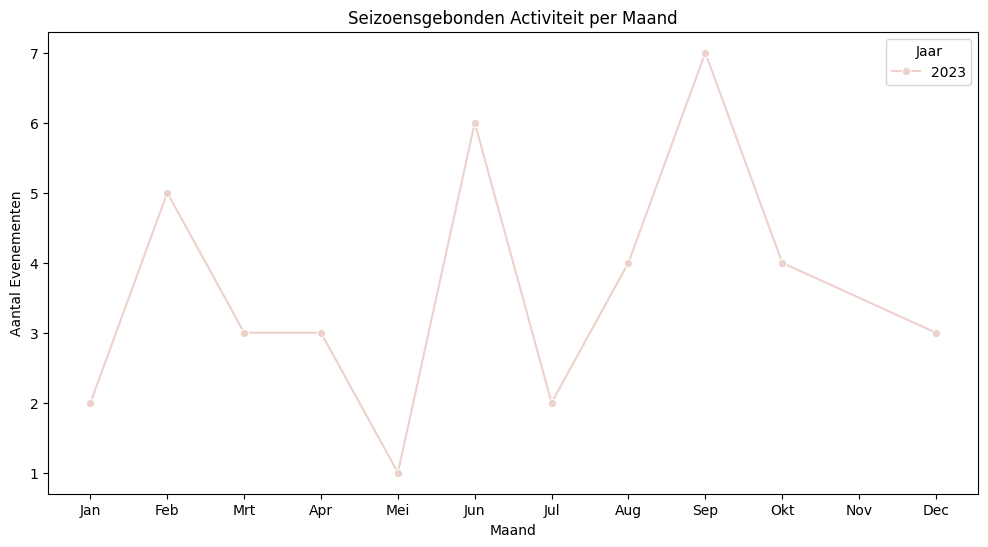

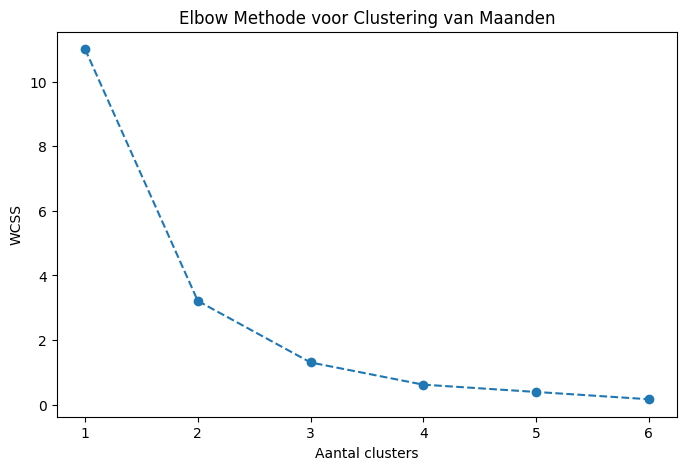

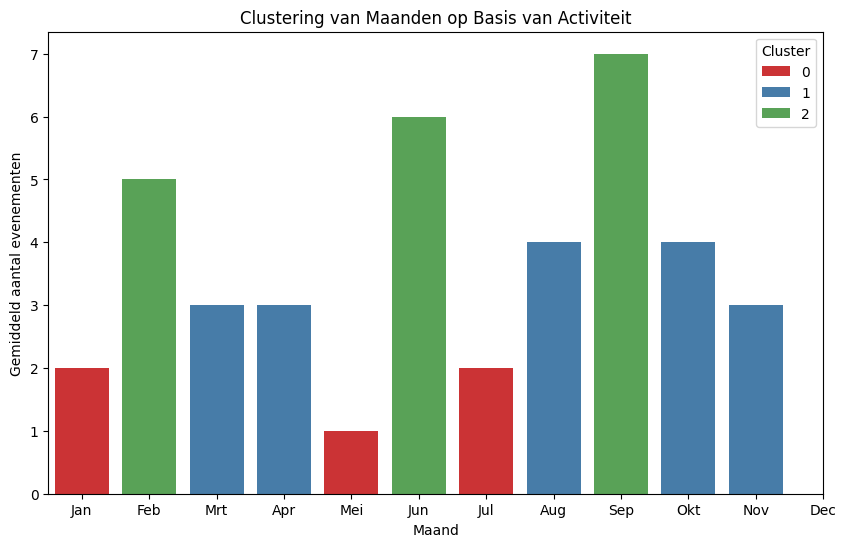

In [2363]:

emifos = evenementinformatie

vereiste_kolommen = {'EvenementID', 'EvenementDatum'}
if not vereiste_kolommen.issubset(evenementinformatie.columns):
    raise KeyError("Ontbrekende kolommen in evenementinformatie")

emifos['EvenementDatum'] = pd.to_datetime(emifos['EvenementDatum'], errors='coerce')

emifos['Jaar'] = emifos['EvenementDatum'].dt.year
emifos['Maand'] = emifos['EvenementDatum'].dt.month
maandelijkse_activiteit = emifos.groupby(['Jaar', 'Maand'])['EvenementID'].count().reset_index()
maandelijkse_activiteit.rename(columns={'EvenementID': 'AantalEvenementen'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=maandelijkse_activiteit, x='Maand', y='AantalEvenementen', hue='Jaar', marker='o')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mrt', 'Apr', 'Mei', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec'])
plt.xlabel("Maand")
plt.ylabel("Aantal Evenementen")
plt.title("Seizoensgebonden Activiteit per Maand")
plt.legend(title="Jaar")
plt.show()


clustering_data = maandelijkse_activiteit.groupby("Maand")["AantalEvenementen"].mean().reset_index()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_data[['AantalEvenementen']])

wcss = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 7), wcss, marker='o', linestyle='--')
plt.xlabel('Aantal clusters')
plt.ylabel('WCSS')
plt.title('Elbow Methode voor Clustering van Maanden')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clustering_data['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.barplot(data=clustering_data, x='Maand', y='AantalEvenementen', hue='Cluster', palette='Set1')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mrt', 'Apr', 'Mei', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec'])
plt.xlabel("Maand")
plt.ylabel("Gemiddeld aantal evenementen")
plt.title("Clustering van Maanden op Basis van Activiteit")
plt.legend(title="Cluster")
plt.show()


3.	Organisatorprestatie

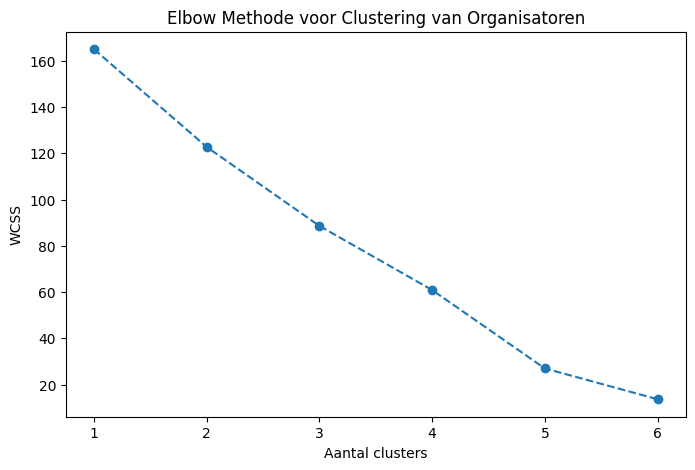

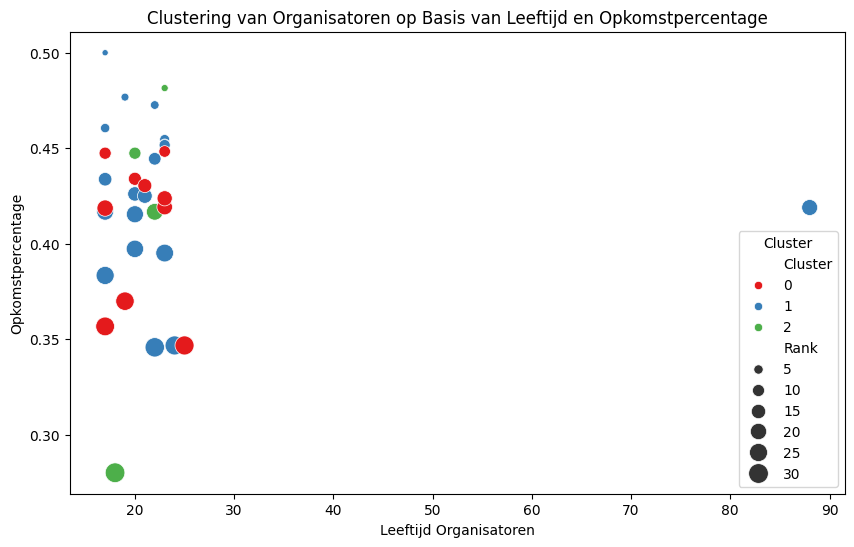

Top 10 Organisatorgroepen op Basis van Opkomstpercentage:
     Leeftijd   Studiejaar  OpkomstPercentage  \
5       17.0  Eerstejaars           0.500000   
29      23.0  Vierdejaars           0.481481   
9       19.0  Eerstejaars           0.476744   
18      22.0  Tweedejaars           0.472603   
7       17.0  Vierdejaars           0.460526   
23      23.0  Eerstejaars           0.454545   
24      23.0  Vierdejaars           0.452055   
25      23.0  Vierdejaars           0.451613   
27      23.0  Tweedejaars           0.448276   
2       17.0  Eerstejaars           0.447368   

    Studierichting_Human Computer Interaction  \
5                                       False   
29                                      False   
9                                       False   
18                                      False   
7                                       False   
23                                      False   
24                                      False   
25                  

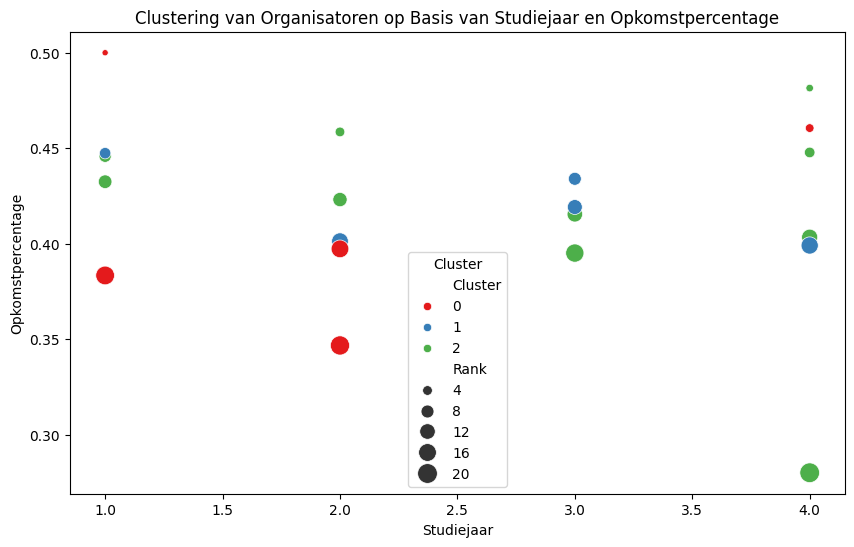

Top 10 Groepen Organisatoren op Basis van Opkomstpercentage (Studierichting, Studiejaar, Lidmaatschapstype):
     Studiejaar  OpkomstPercentage  Studierichting_Human Computer Interaction  \
15           1           0.500000                                      False   
13           4           0.481481                                      False   
19           4           0.460526                                      False   
2            2           0.458515                                      False   
6            4           0.447761                                      False   
7            1           0.447368                                       True   
0            1           0.445783                                      False   
9            3           0.433962                                       True   
12           1           0.432432                                      False   
1            2           0.423077                                      False   

    Studi

In [2364]:
evawzigheid = evenementaanwezigheid

evawzigheid = evawzigheid.merge(evenementinformatie[['EvenementID', 'OrganisatorID']], 
                                                     on='EvenementID', how='left')
evawzigheid = evawzigheid.merge(gebruikersinformatie[['GebruikerID', 'Leeftijd', 'Studierichting', 'Studiejaar', 'Lidmaatschapstype']], 
                                                     left_on='OrganisatorID', right_on='GebruikerID', how='left')

# Stap 2: Bereken opkomstpercentage per groep organisatoren
evawzigheid['Opkomst'] = np.where(evawzigheid['Bijgewoond'] == 1, 1, 0)
opkomst_per_groep = evawzigheid.groupby(['Leeftijd', 'Studierichting', 'Studiejaar', 'Lidmaatschapstype'])['Opkomst'].mean().reset_index()
opkomst_per_groep.rename(columns={'Opkomst': 'OpkomstPercentage'}, inplace=True)

# Stap 3: Converteer categorische variabelen naar numerieke dummies
opkomst_per_groep = pd.get_dummies(opkomst_per_groep, columns=['Studierichting', 'Lidmaatschapstype'], drop_first=True)

# Stap 4: Schaal alleen numerieke variabelen (exclusief categorische kolommen)
numerieke_kolommen = ['Leeftijd'] + [col for col in opkomst_per_groep.columns if 'Studierichting_' in col or 'Lidmaatschapstype_' in col]
X_numeriek = opkomst_per_groep[numerieke_kolommen]

# Schalen van de numerieke waarden
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeriek)

# Stap 5: Clustering met K-Means
# Bepaal het optimale aantal clusters (Elbow-methode)
wcss = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot de Elbow-methode
plt.figure(figsize=(8, 5))
plt.plot(range(1, 7), wcss, marker='o', linestyle='--')
plt.xlabel('Aantal clusters')
plt.ylabel('WCSS')
plt.title('Elbow Methode voor Clustering van Organisatoren')
plt.show()

# Train het K-Means model (bijvoorbeeld met 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
opkomst_per_groep['Cluster'] = kmeans.fit_predict(X_scaled)

# Stap 6: Ranking van organisatoren op basis van opkomstpercentage
opkomst_per_groep['Rank'] = rankdata(-opkomst_per_groep['OpkomstPercentage'], method='dense')  # Hogere opkomst = betere ranking

# Stap 7: Visualisatie van de prestaties
plt.figure(figsize=(10, 6))
sns.scatterplot(data=opkomst_per_groep, x='Leeftijd', y='OpkomstPercentage', hue='Cluster', palette='Set1', size='Rank', sizes=(20, 200))
plt.xlabel("Leeftijd Organisatoren")
plt.ylabel("Opkomstpercentage")
plt.title("Clustering van Organisatoren op Basis van Leeftijd en Opkomstpercentage")
plt.legend(title="Cluster")
plt.show()

# Toon de top 10 groepen organisatoren
top_groepen = opkomst_per_groep.sort_values(by='OpkomstPercentage', ascending=False).head(10)
print("Top 10 Organisatorgroepen op Basis van Opkomstpercentage:\n", top_groepen)


# Stap 1: Converteer 'Studiejaar' naar numerieke waarden
studiejaar_mapping = {
    'Eerstejaars': 1,
    'Tweedejaars': 2,
    'Derdejaars': 3,
    'Vierdejaars': 4,
    # Voeg hier andere studiejaar categorieën toe indien nodig
}

evawzigheid['Studiejaar'] = evawzigheid['Studiejaar'].map(studiejaar_mapping)

# Stap 2: Bereken het opkomstpercentage per groep (Studierichting, Studiejaar, Lidmaatschapstype)
opkomst_per_groep_categorisch = evawzigheid.groupby(['Studierichting', 'Studiejaar', 'Lidmaatschapstype'])['Opkomst'].mean().reset_index()

# Stap 3: Geef het opkomstpercentage een betekenisvolle naam
opkomst_per_groep_categorisch.rename(columns={'Opkomst': 'OpkomstPercentage'}, inplace=True)

# Stap 4: Converteer categorische variabelen naar numerieke dummies
opkomst_per_groep_categorisch = pd.get_dummies(opkomst_per_groep_categorisch, columns=['Studierichting', 'Lidmaatschapstype'], drop_first=True)

# Stap 5: Schaal de numerieke kolommen
numerieke_kolommen_categorisch = ['Studiejaar'] + [col for col in opkomst_per_groep_categorisch.columns if 'Studierichting_' in col or 'Lidmaatschapstype_' in col]
X_numeriek_categorisch = opkomst_per_groep_categorisch[numerieke_kolommen_categorisch]

# Schalen van de numerieke waarden
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_categorisch = scaler.fit_transform(X_numeriek_categorisch)

# Stap 6: Clustering met K-Means (zelfde proces als eerder)
from sklearn.cluster import KMeans
kmeans_categorisch = KMeans(n_clusters=3, random_state=42, n_init=10)
opkomst_per_groep_categorisch['Cluster'] = kmeans_categorisch.fit_predict(X_scaled_categorisch)

# Stap 7: Ranking van organisatoren op basis van opkomstpercentage
from scipy.stats import rankdata
opkomst_per_groep_categorisch['Rank'] = rankdata(-opkomst_per_groep_categorisch['OpkomstPercentage'], method='dense')  # Hogere opkomst = betere ranking

# Stap 8: Visualisatie van de prestaties
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=opkomst_per_groep_categorisch, x='Studiejaar', y='OpkomstPercentage', hue='Cluster', palette='Set1', size='Rank', sizes=(20, 200))
plt.xlabel("Studiejaar")
plt.ylabel("Opkomstpercentage")
plt.title("Clustering van Organisatoren op Basis van Studiejaar en Opkomstpercentage")
plt.legend(title="Cluster")
plt.show()

# Toon de top 10 groepen organisatoren op basis van opkomstpercentage
top_groepen_categorisch = opkomst_per_groep_categorisch.sort_values(by='OpkomstPercentage', ascending=False).head(10)
print("Top 10 Groepen Organisatoren op Basis van Opkomstpercentage (Studierichting, Studiejaar, Lidmaatschapstype):\n", top_groepen_categorisch)

